# Community Selection 
This tutorial provides an minimal example for conducting community-level selection with given selection algorthms.

In [1]:
# Community simulator package
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import numpy as np
import scipy as sp
colors = sns.color_palette()
%matplotlib inline

# Community selection package
from community_selection import *
from community_selection.A_experiment_functions import *
from community_selection.B_community_phenotypes import *
from community_selection.C_selection_algorithms import *
from community_selection.D_migration_algorithms import *

cvxpy not installed. Community.SteadyState() not available.


# Library of algorithms
List of algorithms in computing community phenotypes, selection algorithms, and migration algorithms.

In [2]:
make_algorithm_library()

,AlgorithmType,AlgorithmName
0,community_phenotype,f1_community_function_additive
1,community_phenotype,f2_community_function_interaction
2,community_phenotype,f3_community_function_additive_binary
3,community_phenotype,f4_community_function_interaction_binary
4,community_phenotype,f5_invasion_growth
5,community_phenotype,f6_resident_growth
0,selection_algorithm,no_selection
1,selection_algorithm,select_top25percent
2,selection_algorithm,select_top10percent
3,selection_algorithm,select_bottom25percent


# Examples
1. Set up parameters 
2. Make inital state and put together consumer and resource initial states into a plate
3. Simulate the community

Set up the simulation parameters 

In [3]:
# Make dynanmics by default we will use the microbial consumer resource model
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

# Assumptions
assumptions = a_default.copy() # Start with default parameters
assumptions.update({'n_wells':24, 'c1' :0.1, 'muc':1, 'm':0, "response":"type III",
                    'q': 0.5,
                   'SA': np.concatenate([[10], 60*np.ones(3)]), 'MA': np.concatenate([[10], 30*np.ones(3)])}) # Concatenate to creat a super family
assumptions["sigma"] = 1 # Standard deviation for drawing specifc speices/interaction function
assumptions["alpha"] = 1 # Scaling factor between species- and interaction-specific function variances

# Prepare experiment setup 
params, species_pool, species_function, interaction_function = prepare_experiment(assumptions, seed = 1)

## Simulation parameters
params_simulation = {
    "n_propagation": 24, # Length of propagation, or hours within a growth cycle
    "n_transfer": 5, # Number of transfer, or number of passage
    "dilution": 1/1000, # Dilution factor for transfer
    "pool": species_pool
}

In [4]:
def select_community(params_algorithm = {"community_phenotype": "f1_community_function_additive", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"}):
    """
    Wrapper function for running control(screening) and selection given the selection algorithms and communtiy phenotype
    """
    # Control plate
    np.random.seed(2)
    # Make initial state
    init_state = MakeInitialState(assumptions)
    # Make plate
    plate = Community(init_state, dynamics, params, scale = 10**6, parallel = True) 
    setattr(plate, "species_function", species_function)
    setattr(plate, "interaction_function", interaction_function)
    # Simulation
    ctrl_plate_df, ctrl_function_df = simulate_community(plate, assumptions = assumptions, params_simulation = params_simulation, params_algorithm = {"community_phenotype": params_algorithm["community_phenotype"], "selection_algorithm": "no_selection", "migration_algorithm": params_algorithm["migration_algorithm"]}, write_composition = False)

    # Selection plate
    np.random.seed(2)
    # Make initial state
    init_state = MakeInitialState(assumptions)
    # Make plate
    plate = Community(init_state, dynamics, params, scale = 10**6, parallel = True) 
    setattr(plate, "species_function", species_function)
    setattr(plate, "interaction_function", interaction_function)
    # Simulation
    selection_plate_df, selection_function_df = simulate_community(plate, assumptions = assumptions, params_simulation = params_simulation, params_algorithm = params_algorithm, write_composition = False)

    return ctrl_function_df, selection_function_df

# F1: additive function 
$f_1=\sum{\lambda_i n_i}$

In [24]:
f1_ctrl, f1_selc = select_community(params_algorithm = {"community_phenotype": "f1_community_function_additive", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done


KeyboardInterrupt: 

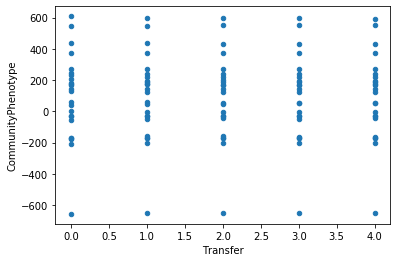

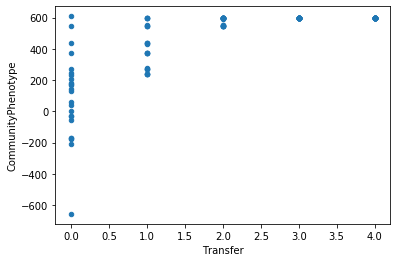

In [6]:
plot_community_function(f1_ctrl)
plot_community_function(f1_selc)

# F2: additive function with interaction term
$f_2=\sum{\lambda_i n_i} + \sum{\lambda_{ij} n_i n_j}$

In [13]:
f2_ctrl, f2_selc = select_community(params_algorithm = {"community_phenotype": "f2_community_function_interaction", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


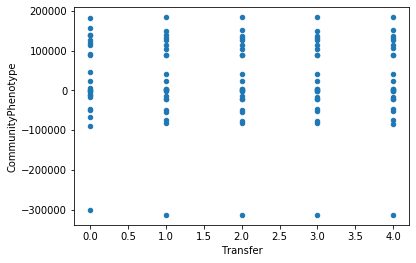

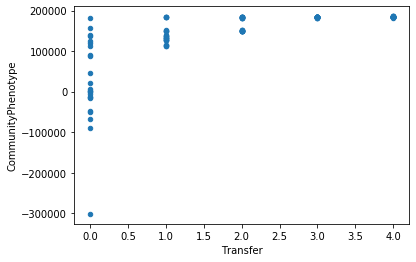

In [15]:
plot_community_function(f2_ctrl)
plot_community_function(f2_selc)

# F3: binary additive function
$f_3 = \sum{\lambda_i}$

In [16]:
f3_ctrl, f3_selc = select_community(params_algorithm = {"community_phenotype": "f3_community_function_additive_binary", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


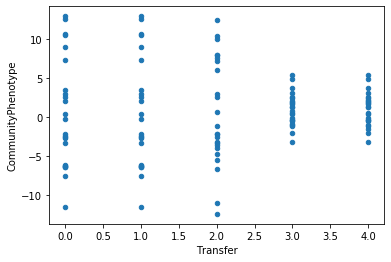

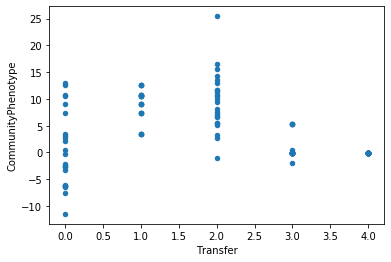

In [17]:
plot_community_function(f3_ctrl)
plot_community_function(f3_selc)

# F4: binary addtive function with interactions
$f_4 = \sum{\lambda_i} + \sum{\lambda_{ij}}$

In [18]:
f4_ctrl, f4_selc = select_community(params_algorithm = {"community_phenotype": "f4_community_function_interaction_binary", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


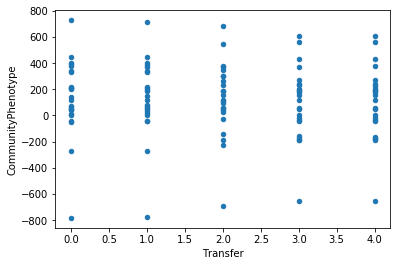

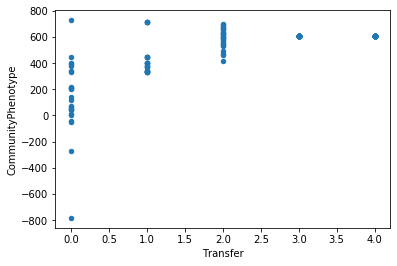

In [19]:
plot_community_function(f4_ctrl)
plot_community_function(f4_selc)

# F5: resistence
$f_5 = x_p(t)/x_p(0)$, where $x_p(t)$ is the invasive pathgen biomass after growing with the community, $x_p(0)$ is the invasive pathogen biomass at the time of invasion 

In [20]:
f5_ctrl, f5_selc = select_community(params_algorithm = {"community_phenotype": "f5_invasion_growth", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


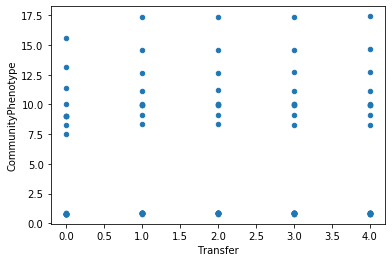

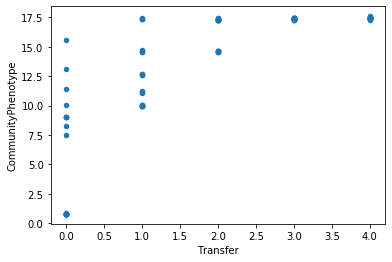

In [21]:
plot_community_function(f5_ctrl)
plot_community_function(f5_selc)



# F6: resident growth
$f_6 = x_p(t)/x_p^*(t)$, where $x_p(t)$ is the pathogen biomass grown with the coalscenced community, $x_p^*(t)$ is the pathogen biomass grown with its residential community

In [5]:
f6_ctrl, f6_selc = select_community(params_algorithm = {"community_phenotype": "f6_resident_growth", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


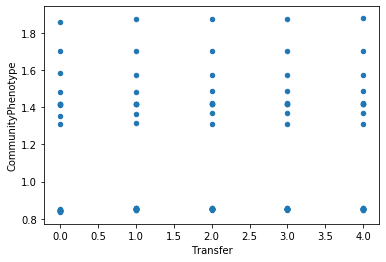

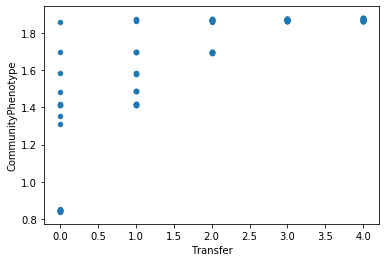

In [6]:
plot_community_function(f6_ctrl)
plot_community_function(f6_selc)

# Output the result


In [3]:
def concat_result(f_ctrl, f_selc, species_pool_seed, phenotype_algorithm = "f6_resident_growth", selection_algorithm = "select_best_n"):
    """
    Concatenate the result data.frame from control (no-selection) and selection experiment
    """
    # 
    f_ctrl["Experiment"] = "control"
    f_selc["Experiment"] = "selection"
    
    #
    f_result = pd.concat([f_ctrl, f_selc])
    f_result["SelectionAlgorithmName"] = selection_algorithm
    f_result["CommunityPhenotypeName"] = phenotype_algorithm
    f_result["SpeciesPool"] = species_pool_seed

    # Write the result
    f_result.to_csv("data/" + selection_algorithm + "-" + phenotype_algorithm + "-pool" + str(species_pool_seed) + ".txt", index = False)


,AlgorithmType,AlgorithmName
0,community_phenotype,f1_community_function_additive
1,community_phenotype,f2_community_function_interaction
2,community_phenotype,f3_community_function_additive_binary
3,community_phenotype,f4_community_function_interaction_binary
4,community_phenotype,f5_invasion_growth
5,community_phenotype,f6_resident_growth
0,selection_algorithm,no_selection
1,selection_algorithm,select_top25percent
2,selection_algorithm,select_bottom25percent
0,migration_algorithm,no_migration


In [62]:
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f1_community_function_additive", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f2_community_function_interaction", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f3_community_function_additive_binary", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f4_community_function_interaction_binary", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f5_invasion_growth", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f6_resident_growth", selection_algorithm = "select_top25percent")


# Selection algorithms

In [11]:
def plot_transfer_matrix(transfer_matrix):
    fig,ax=plt.subplots()
    sns.heatmap(transfer_matrix,ax=ax)
    ax.set_xlabel('Old well',fontsize=14)
    ax.set_ylabel('New well',fontsize=14)
    ax.set_title(r'Transfer Matrix $f$',fontsize=14)
    plt.show()

def no_selection(community_function):
    """
    Direct well-to-well transfer without selection
    """
    # Read number of wells 
    n = len(community_function)
    return np.eye(n)
    
def select_top25percent(community_function):
    """
    Select the top 25% communities 
    """
    # Read number of wells 
    n = len(community_function)
    
    # Sort the community function in this transfer
    sorted_community_function = np.sort(community_function)
    
    # 25% cutoff for selecting communities
    cut_off = sorted_community_function[int(np.round(len(community_function)*(1-0.25))) - 1]
    
    # Winner wells
    winner_index = np.where(community_function >= cut_off)[0][::-1] # Reverse the list so the higher 
    
    # Transfer matrix
    transfer_matrix = np.zeros((n,n))
    t_new = range(n) # New wells
    t_old = np.repeat(winner_index, int(np.round(1/0.25))) # Old wells
    t_old = t_old[:n] # Slice the first n elements
        
    # Fill in the transfer matrix
    for i in range(n):
        transfer_matrix[t_new[i], t_old[i]] = 1
  
    return transfer_matrix


def select_top10percent(community_function):
    """
    Select the top 10% communities 
    """
    # Read number of wells 
    n = len(community_function)
    
    # Sort the community function in this transfer
    sorted_community_function = np.sort(community_function)
    
    # 25% cutoff for selecting communities
    cut_off = sorted_community_function[int(np.round(len(community_function)*(1-0.1))) - 1]
    
    # Winner wells
    winner_index = np.where(community_function >= cut_off)[0][::-1] # Reverse the list so the higher 
    
    # Transfer matrix
    transfer_matrix = np.zeros((n,n))
    t_new = range(n) # New wells
    t_old = np.repeat(winner_index, int(np.round(1/0.1))) # Old wells
    t_old = t_old[:n] # Slice the first n elements
        
    # Fill in the transfer matrix
    for i in range(n):
        transfer_matrix[t_new[i], t_old[i]] = 1
  
    return transfer_matrix

def select_bottom25percent(community_function):
    """
    Select the bottom 25% communities
    """
    # Read number of wells 
    n = len(community_function)
    
    # Sort the community function in this transfer
    sorted_community_function = np.sort(community_function)
    
    # 25% cutoff for selecting communities
    cut_off = sorted_community_function[int(np.round(len(community_function)*(0.25)))]
    
    # Winner wells
    winner_index = np.where(community_function <= cut_off)[0] # Reverse the list so the higher 
    
    # Transfer matrix
    transfer_matrix = np.zeros((n,n))
    t_new = range(n) # New wells
    t_old = np.repeat(winner_index, int(np.round(1/0.25))) # Old wells
    t_old = t_old[:n] # Slice the first n elements
        
    # Fill in the transfer matrix
    for i in range(n):
        transfer_matrix[t_new[i], t_old[i]] = 1
  
    return transfer_matrix

def pool_top25percent(community_function):
    """
    Select the top 25% communities, pool them all together, and replicate to all the new wells
    """    
    # Read number of wells 
    n = len(community_function)
    
    # Sort the community function in this transfer
    sorted_community_function = np.sort(community_function)
    
    # 25% cutoff for selecting communities
    cut_off = sorted_community_function[int(np.round(len(community_function)*(1-0.25))) - 1]
    
    # Winner wells
    winner_index = np.where(community_function > cut_off)[0][::-1] # Reverse the list so the higher 
    
    # Transfer matrix
    transfer_matrix = np.zeros((n,n))
    transfer_matrix[:, winner_index] = 1
  
    return transfer_matrix 


def pair_top(community_function):
    """
    Pair the top communities. Each pairwise combination has two replicates
    """
    import itertools
    
    # Read number of wells
    n = len(community_function)

    # Compute the cutoff based on the number of wells
    cut_off_percent = (np.sqrt(n))/n

    # Sort the community function in this transfer
    sorted_community_function = np.sort(community_function)
    
    # Community function value cutoff for selecting communities    
    cut_off = sorted_community_function[int(np.round(len(community_function)*(1-cut_off_percent))) - 1]
    
    # Winner wells
    winner_index = np.where(community_function > cut_off)[::-1] # Reverse the list so the higher 
    pairs_list = list(itertools.combinations(winner_index[0], 2))
    
    # Transfer matrix
    transfer_matrix = np.zeros((n,n))
    t_new = range(n) # New wells
    t_old = list(winner_index) + [pairs_list * int(np.round(1/cut_off_percent))] # Old wells
    t_old2 = []
    for i in t_old:
        for j in i:
            t_old2.append(j)
    
    t_old2 = t_old2[:n] # Slice the first n elements
        
    # Fill in the transfer matrix
    for i in range(n):
        transfer_matrix[t_new[i], t_old2[i]] = 1
    
    return transfer_matrix


def direct_selection(community_function):
    """
    Select top 25%, discard the rest. Asexually reproduce the top 10%, and the migrate from species pool to the rest 90% 
    """
    # Read number of wells 
    n = len(community_function)

    # Sort the community function in this transfer
    sorted_community_function = np.sort(community_function)

    # 25% cutoff for selecting communities
    cut_off = sorted_community_function[int(np.round(len(community_function)*(1-0.25)) - 1)]

    # Winner wells
    winner_index = np.where(community_function >= cut_off)[0][::-1] # Reverse the list so the higher 

    # Transfer matrix
    transfer_matrix = np.zeros((n,n))
    t_new = range(n) # New wells
    t_old = np.concatenate((winner_index, np.repeat(winner_index, int(np.round(1/0.25)))))
    t_old = t_old[:n] # Slice the first n elements
        
    # Fill in the transfer matrix
    for i in range(n):
        transfer_matrix[t_new[i], t_old[i]] = 1
  
    return transfer_matrix

    

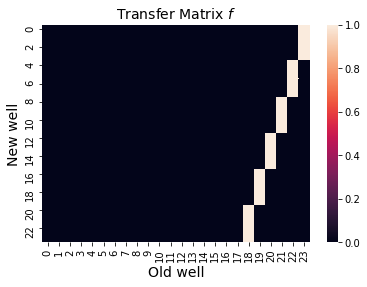

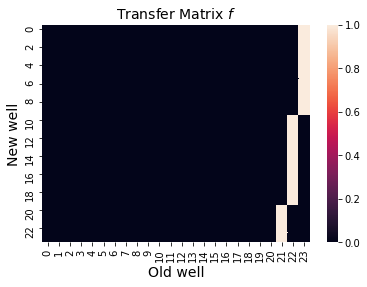

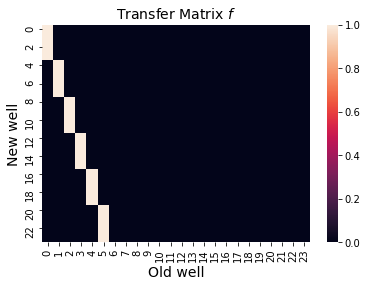

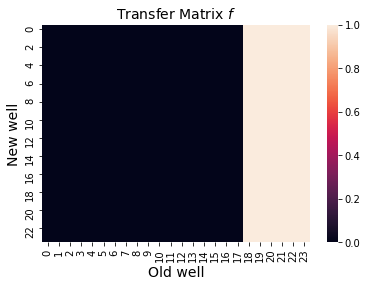

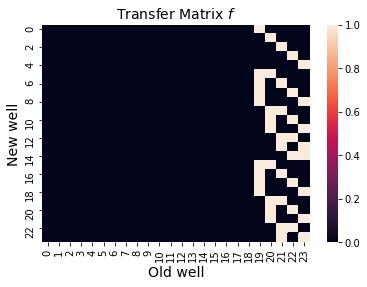

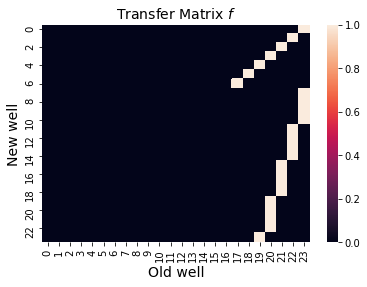

In [13]:
plot_transfer_matrix(select_top25percent(range(24)))
plot_transfer_matrix(select_top10percent(range(24)))
plot_transfer_matrix(select_bottom25percent(range(24)))
plot_transfer_matrix(pool_top25percent(range(24)))
plot_transfer_matrix(pair_top(range(24)))
plot_transfer_matrix(direct_selection(range(24)))

In [7]:
make_algorithm_library()

,AlgorithmType,AlgorithmName
0,community_phenotype,f1_community_function_additive
1,community_phenotype,f2_community_function_interaction
2,community_phenotype,f3_community_function_additive_binary
3,community_phenotype,f4_community_function_interaction_binary
4,community_phenotype,f5_invasion_growth
5,community_phenotype,f6_resident_growth
0,selection_algorithm,no_selection
1,selection_algorithm,select_top25percent
2,selection_algorithm,select_top10percent
3,selection_algorithm,select_bottom25percent
